# VAR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller

In [2]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
ipe_df['contTime'] = pd.to_datetime(ipe_df.contTime)
data = ipe_df.drop(['contTime'], axis=1)
data.index = ipe_df.contTime

In [4]:
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily['2016':'2020']

In [6]:
ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1, inplace=True)

In [7]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [8]:
#missing value treatment
cols = ipe_interp.columns
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = ipe_interp.drop(['Turb_FNU'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([0.12770293, 0.09675386, 0.03364757, 0.00254654, 0.00029707])

In [9]:
#creating the train and validation set
train = ipe_interp[:int(0.8*(len(ipe_interp)))]
valid = ipe_interp[int(0.8*(len(ipe_interp))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(365)

# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

In [10]:
ipe_interp

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
contTime,,,,,,
2016-01-01,3.102660,2.183437,0.414479,10.745625,3.837323,141.426042
2016-01-02,3.067604,1.616771,0.343750,10.761146,3.853583,141.876042
2016-01-03,2.683125,1.437579,0.331771,10.710938,4.008771,143.057292
2016-01-04,2.285312,1.182526,0.215104,10.576771,4.066344,143.029167
2016-01-05,2.225938,1.189271,0.254583,10.527188,4.116604,142.786458
...,...,...,...,...,...,...
2020-12-27,4.713474,0.442796,0.638495,6.953474,3.495432,138.068421
2020-12-28,4.657604,0.481429,0.708132,6.885625,3.478885,137.610417
2020-12-29,4.382604,0.449896,0.640842,6.684062,3.506271,137.482292


In [11]:
ipe_sq = np.sqrt(ipe_interp)

C:\Users\harri\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


In [12]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,6):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Turb_FNU is :  3.8908313967700496
rmse value for Chloro_RFU is :  3.785661708521854
rmse value for BGA_RFU is :  1.3615077359886016
rmse value for ODO_mgL is :  2.3008564034344365
rmse value for Temp_C is :  2.4590614726297244
rmse value for Cond_muSCm is :  37.888828106833884


In [13]:
#make final predictions
model = VAR(endog=ipe_sq.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)
print(yhat)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[[ 2.22419636  0.86548416  0.78819716  2.73234002  1.79540436 11.57135395]
 [ 2.7770744   1.0275256   0.82206832  2.77373455  1.91749605 11.63495233]
 [ 2.39081725  0.98076791  0.81671496  2.49155964  2.00723412 11.81705651]
 ...
 [ 0.69216861 -0.54908402 -0.1145295   1.61459142  3.51707891 13.96776503]
 [ 1.18857042 -0.81380189 -0.52479268  1.60168466  3.58498353 13.9925041 ]
 [ 1.42299844 -1.04359957 -0.28699981  1.78064369  3.67894316 14.00884446]]


In [19]:
model_fit.endog_lagged

array([[ 1.        ,  1.13435922,  0.3127499 , ...,  3.27805201,
         1.9589086 , 11.89226815],
       [ 1.        ,  1.14641652,  0.30838963, ...,  3.28041855,
         1.96305459, 11.91117298],
       [ 1.        ,  1.13568995,  0.31490739, ...,  3.27275687,
         2.00219151, 11.96065599],
       ...,
       [ 1.        ,  2.15814832,  0.69385054, ...,  3.07509521,
         1.85845437, 10.94930904],
       [ 1.        ,  2.09346702,  0.67074275, ...,  3.08484197,
         1.87053357, 10.93131968],
       [ 1.        ,  2.02199858,  0.64959924, ...,  3.04274211,
         1.88978294, 11.03450112]])

C:\Users\harri\AppData\Local\Temp\ipykernel_26984\2726377545.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(ipe_interp['2020'])


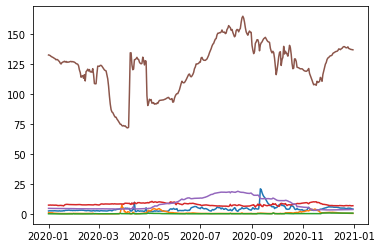

In [16]:
plt.plot(ipe_interp['2020'])

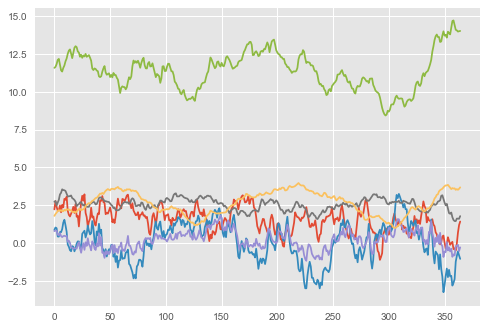

In [22]:
plt.style.use('ggplot')
plt.plot((yhat))